In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import re
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, HuberRegressor, RANSACRegressor, TheilSenRegressor, SGDRegressor
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

#plt.style.use('dark_background')

In [2]:
df = pd.read_csv('listings.csv')

In [3]:
# Since zip_code was from our query and not pulled from
# AirBnB itself, we'll need to drop it as it won't give us
# accurate insights or information.
df.drop('zip_code', axis = 1, inplace = True)

In [4]:
# Drop duplicates - after going through our data, it looks like the date does not have a strong correlation so we will drop those duplicates as well
df.drop_duplicates(['title', 'listing_type', 'city',
                   'numerical_descriptors', 'amenities'],
                   inplace = True)
df.reset_index(drop = True, inplace = True)

In [5]:
# orig_price = list(df[df['discounted'] == 1].index)
# df.loc[orig_price, 'price_per_night'] = df.loc[orig_price, 'original_value']

In [6]:
# Drop some columns that we determined as insignificant as well as some text based columns
df.drop(['title', 'num_reviews', 'rating', 'dates'], axis = 1, inplace = True)
df = df.reset_index(drop = True)

# Some simple cleaning and adjustments
df = df.rename({"city": "area"}, axis = 1)
df['discounted'] = df['discounted'].astype(int)

In [7]:
# Create dummies for area and listing_type - drop the first columns
areas = pd.get_dummies(df['area'], drop_first = True)
# dates = pd.get_dummies(df['dates'], drop_first = True)
listing_types = pd.get_dummies(df['listing_type'], drop_first = True)
df.drop(['area', 'listing_type'], axis = 1, inplace = True)

In [8]:
# Concatenate the 3 dfs
df = pd.concat([df, areas, listing_types], axis = 1)

In [9]:
# Convert the amenities into a list so we can use MLB
def str_to_list(amenities_str):
    if amenities_str == 'None':
        return []
    else:
        return amenities_str.strip().split(' - ')
    
df['amenities'] = df['amenities'].fillna('None')
df['amenities'] = df['amenities'].apply(str_to_list)

# Use MultiLabelBinarizer from scikit to encode
mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(df['amenities']), columns = mlb.classes_)

# Concatenate the df with amenities and drop the amenities column
df.drop('amenities', axis = 1, inplace = True)
df = pd.concat([df, amenities_df], axis = 1)

In [10]:
def guest_num(nd_list):
    for nd_str in nd_list:
        if 'guest' in str.lower(nd_str):
            guest_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return guest_n
    return 0

def bedroom_num(nd_list):
    for nd_str in nd_list:
        if 'bedroom' in str.lower(nd_str):
            bedroom_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return bedroom_n
        elif 'studio' in str.lower(nd_str):
            nd_list.remove(nd_str)
            return 1
    return 0

def bed_num(nd_list):
    for nd_str in nd_list:
        if 'bed' in str.lower(nd_str):
            bed_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return bed_n
    return 0

def sharedbath_num(nd_list):
    for nd_str in nd_list:
        if 'shared bath' in str.lower(nd_str):
            sbath_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return sbath_n
    return 0

def bath_num(nd_list):
    for nd_str in nd_list:
        if 'half-bath' in str.lower(nd_str):
            nd_list.remove(nd_str)
            return .5
        if 'bath' in str.lower(nd_str):
            bath_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return bath_n
    return 0

In [11]:
df['numerical_descriptors'] = df['numerical_descriptors'].apply(str_to_list)

df['guests'] = df['numerical_descriptors'].apply(guest_num)
df['bedrooms'] = df['numerical_descriptors'].apply(bedroom_num)
df['beds'] = df['numerical_descriptors'].apply(bed_num)
df['shared baths'] = df['numerical_descriptors'].apply(sharedbath_num)
df['baths'] = df['numerical_descriptors'].apply(bath_num)


In [12]:
# guest_dummies = pd.get_dummies(df['guests'], drop_first = True)
# bedroom_dummies = pd.get_dummies(df['bedrooms'], drop_first = True)
# bed_dummies = pd.get_dummies(df['beds'], drop_first = True)
# sbath_dummies = pd.get_dummies(df['shared baths'], drop_first = True)
# bath_dummies = pd.get_dummies(df['baths'], drop_first = True)

# df = pd.concat([df, guest_dummies, bedroom_dummies, bed_dummies, sbath_dummies, bath_dummies], axis = 1)
df.drop('numerical_descriptors', axis = 1, inplace = True)

In [13]:
# If not discounted, fill in original_value with current price
df['original_value'] = df['original_value'].fillna(df['price_per_night'])

# If we look up how fees are calculated, we find out that the service fee is automatic.
# It is determined by AirBnB itself and has a formula:
# .14 * (n * p + c)
# where n is the number of nights
# p is the price per night
# c is the cleaning fee

# When putting up a listing or getting an idea of a listing, service fee does not come into play
# If I'm a host, I wouldn't know the service fee before putting my listing up
# If I'm a guest, I wouldn't use service fee as a parameter (neither would I use cleaning fee)

df.drop(['service_fee', 'cleaning_fee'], axis = 1, inplace = True)

df.drop(['original_value'], axis = 1, inplace = True)

In [14]:
# # Subtract the imputed fees from the price_per_night
# df_train.loc[msfee, 'price_per_night'] -= df_train.loc[msfee, 'service_fee']/2
# df_train.loc[mcfee, 'price_per_night'] -= df_train.loc[mcfee, 'cleaning_fee']/2

# df_test.loc[msfee_test, 'price_per_night'] -= df_test.loc[msfee_test, 'service_fee']/2
# df_test.loc[mcfee_test, 'price_per_night'] -= df_test.loc[mcfee_test, 'service_fee']/2

In [15]:
# erroneous_train = list(df_train[df_train['price_per_night'] < 0].index)
# erroneous_test = list(df_test[df_test['price_per_night'] < 0].index)
# # erroneous += list(df[df['rating'] > 5].index)
# df_train.drop(erroneous_train, inplace = True)
# df_test.drop(erroneous_test, inplace = True)

In [16]:
random_state = np.random.randint(1634)

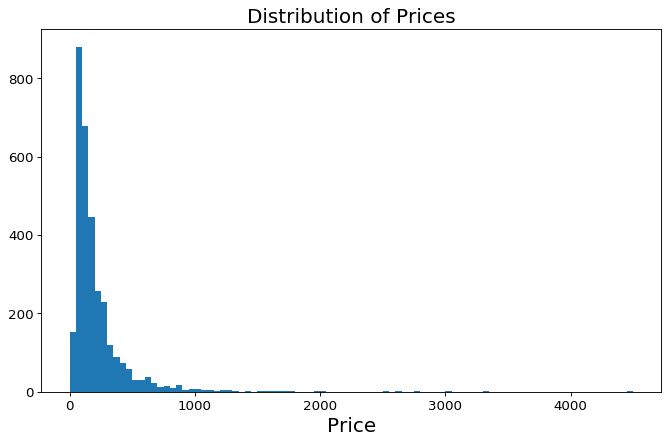

In [17]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.hist(df['price_per_night'], bins=np.linspace(0,4500, 91))
plt.title('Distribution of Prices', fontsize = 18)
plt.xlabel('Price', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images/ydist.png')

In [18]:
df.to_csv('adjlistingsv2.csv', index = False)

***

***

***

In [19]:
X = df.drop('price_per_night', axis = 1)
y = df['price_per_night']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = random_state)
model = LinearRegression()
model_fit = model.fit(X_train, y_train)
print("R2_train:", model_fit.score(X_train, y_train))
print("R2_test:", model_fit.score(X_test, y_test))

X_trainsm, X_testsm = X_train.copy(), X_test.copy()
X_trainsm['constant'] = 1
X_testsm['constant'] = 1
modelsm = sm.OLS(y_train, X_trainsm)
modelsm_fit = modelsm.fit()
modelsm_fit.summary()

R2_train: 0.5285924455255901
R2_test: -2.7115044724599955e+19


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_night   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     13.18
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          8.72e-265
Time:                        16:50:07   Log-Likelihood:                -17116.
No. Observations:                2577   AIC:                         3.464e+04
Df Residuals:                    2374   BIC:                         3.583e+04
Df Model:                         202                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
discounted                   -66.3221     13.931     -4.761      0.000     -93.640     -39.005
Albany                        14.4158     60.479      0.238      0.812    -104.181     133.013
Atchison Village              14.8387    197.626      0.075      0.940    -372.699     402.377
Atherton                     -27.2610    195.715     -0.139      0.889    -411.052     356.530
Balboa Terrace               150.6197    114.559      1.315      0.189     -74.026     375.266
Bayview                       -8.6382     45.105     -0.192      0.848     -97.086      79.810
Belding/Woods               -209.4054    145.842     -1.436      0.151    -495.396      76.585
Belmont                       21.5291     49.118      0.438      0.661     -74.789     117.847
Belvedere Tiburon            396.9829    194.894      2.037      0.042      14.803     779.163
Berkeley                      55.6392     42.824      1.299      0.194     -28.336     139.615
Berkeley Hills                68.5378     54.985      1.246      0.213     -39.285     176.361
Bernal Heights                68.4374     43.944      1.557      0.120     -17.735     154.610
Brisbane                     412.3647    118.145      3.490      0.000     180.686     644.044
Burlingame                    17.4789     35.951      0.486      0.627     -53.020      87.978
Castro Valley                -15.8908    138.825     -0.114      0.909    -288.121     256.340
Central Berkeley              41.3858     77.217      0.536      0.592    -110.034     192.806
Chinatown                    173.0063     44.080      3.925      0.000      86.568     259.445
Civic Center                 157.4329    210.754      0.747      0.455    -255.847     570.713
Clawson                        1.7295     82.845      0.021      0.983    -160.726     164.185
Clinton                        6.7585     82.122      0.082      0.934    -154.280     167.797
Cole Valley                  413.4581    116.630      3.545      0.000     184.751     642.165
Coronado                     -13.3980    195.183     -0.069      0.945    -396.146     369.350
Corte Madera                 261.0305     68.002      3.839      0.000     127.681     394.379
Cow Hollow                   192.8114     51.816      3.721      0.000      91.202     294.421
Crocker Amazon               -57.4733     50.804     -1.131      0.258    -157.097      42.151
Daly City                    -29.4144     27.653     -1.064      0.288     -83.641      24.812
Dogpatch                     134.1863    195.016      0.688      0.491    -248.234     516.606
Dogtown                      -39.7551     60.523     -0.657      0.511    -158.438      78.928
Downtown                     151.0159     35.078      4.305      0.000      82.228     219.803
Downtown Berkeley            -18.3959    10

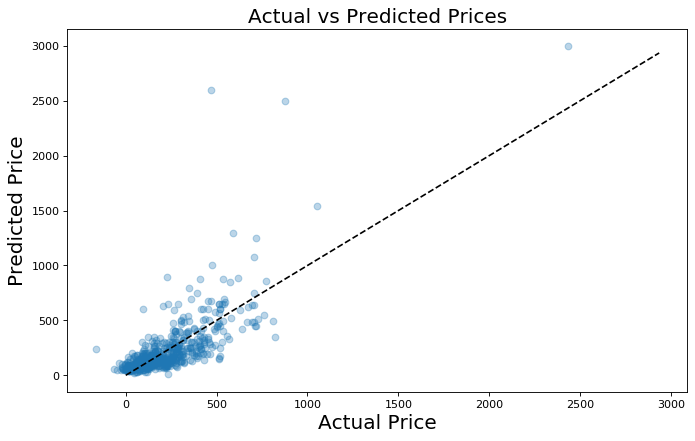

In [20]:
plt.figure(figsize = (10, 6), dpi = 80)
line = np.linspace(0,max(modelsm_fit.predict(X_testsm)) + 500,10001)
plt.scatter(modelsm_fit.predict(X_testsm), y_test, alpha = 0.3)
plt.plot(line, line, 'k--')
plt.xlabel('Actual Price', fontsize = 18)
plt.ylabel('Predicted Price', fontsize = 18)
plt.title('Actual vs Predicted Prices', fontsize = 18)
plt.savefig('images/basepred.png')

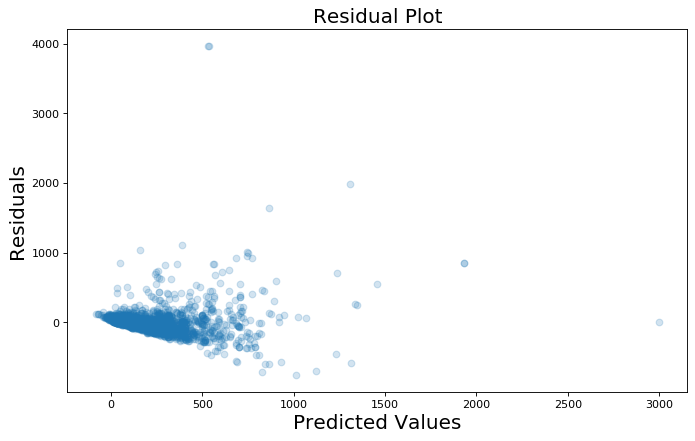

In [21]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.scatter(modelsm_fit.predict(X_trainsm), modelsm_fit.resid, alpha = 0.2)
plt.xlabel('Predicted Values', fontsize = 18)
plt.ylabel('Residuals', fontsize = 18)
plt.title('Residual Plot', fontsize = 18)
plt.savefig('images/baseres.png')

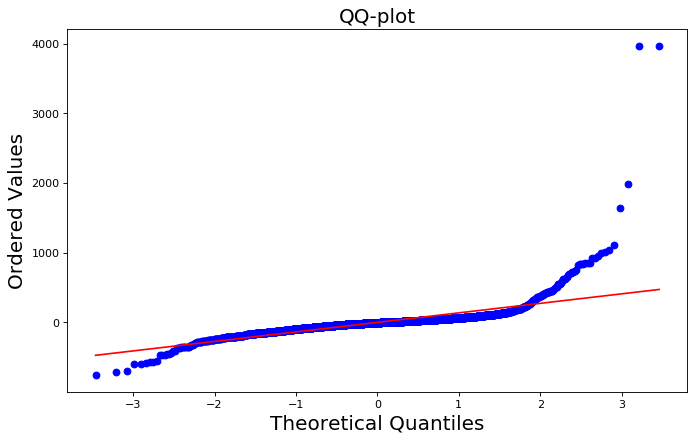

In [22]:
plt.figure(figsize = (10, 6), dpi = 80)
stats.probplot(modelsm_fit.resid, dist = 'norm', plot = plt)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Ordered Values', fontsize = 18)
plt.title('QQ-plot', fontsize = 18)
plt.savefig('images/baseqq.png')

# Summary

* Errors are not normally distributed - try transformations later on
* Many features seem to have a high p-value so we may need to drop those

***

***

***

# Model 2

Let's try removing any features with a p-value of greater than 0.05

In [23]:
drop_cols = list(modelsm_fit.pvalues[modelsm_fit.pvalues > 0.05].index)

if 'constant' in drop_cols:
    drop_cols.remove('constant')
dfadj = df.drop(drop_cols, axis = 1)

In [24]:
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

dfadj2 = dfadj.copy()
while True:
    X = dfadj2.drop('price_per_night', axis = 1)
    y = dfadj2['price_per_night']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
    model = LinearRegression()
    model_fit = model.fit(X_train, y_train)
    print("R2_train:", model_fit.score(X_train, y_train))
    print("R2_test:", model_fit.score(X_test, y_test))

    X_trainsm, X_testsm = X_train.copy(), X_test.copy()
    X_trainsm['constant'] = 1
    X_testsm['constant'] = 1
    modelsm = sm.OLS(y_train, X_trainsm)
    modelsm_fit = modelsm.fit()
    
    drop_cols = list(modelsm_fit.pvalues[modelsm_fit.pvalues > 0.05].index)
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    drop_cols += list(vif[vif['vif'] > 10]['variables'])
    if 'constant' in drop_cols:
        drop_cols.remove('constant')
    
    print(drop_cols)
    dfadj2 = dfadj2.drop(drop_cols, axis = 1)
    
    if len(drop_cols) == 0:
        break

R2_train: 0.4637770570703523
R2_test: -6.3829898844369e+20
['Mission Terrace', 'North Beach', 'hostel beds', 'hut', 'Gas fireplace', 'Massage table', 'bedrooms']
R2_train: 0.48325067416248313
R2_test: 0.4032933635959268
['entire vacation home']
R2_train: 0.4931517117212453
R2_test: -3.8122610642114534e+17
['Brisbane', 'Corte Madera', 'The Castro']
R2_train: 0.4407342461566067
R2_test: 0.5116917922135013
['Cole Valley', 'Emeryville', 'Pacific Heights', 'Tiburon']
R2_train: 0.44452880686111984
R2_test: 0.5209743321933148
['Belvedere Tiburon', 'Tenderloin']
R2_train: 0.4563212640303601
R2_test: 0.49048183204994045
['Muir Beach']
R2_train: 0.4699760260609237
R2_test: 0.36216098091986815
['Hillsborough']
R2_train: 0.4256847243112426
R2_test: 0.5625788289597533
[]


In [25]:
dfadj.shape

(3222, 36)

In [26]:
modelsm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_night   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     118.6
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          1.50e-293
Time:                        16:50:12   Log-Likelihood:                -17372.
No. Observations:                2577   AIC:                         3.478e+04
Df Residuals:                    2560   BIC:                         3.488e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
discounted              -56.4590     14.198     -3.977      0.000     -84.299     -28.619
Chinatown               161.2179     35.685      4.518      0.000      91.244     231.192
Cow Hollow              139.8987     36.058      3.880      0.000      69.192     210.605
Downtown                111.5551     25.155      4.435      0.000      62.228     160.882
Fisherman's Wharf       410.5094     42.184      9.731      0.000     327.791     493.228
Marina                  557.3937     50.851     10.961      0.000     457.680     657.107
Mill Valley             130.6639     32.566      4.012      0.000      66.805     194.522
Mission District         84.2585     32.819      2.567      0.010      19.905     148.612
Nob Hill                 83.8076     32.097      2.611      0.009      20.868     146.747
Pacifica                130.0729     23.569      5.519      0.000      83.856     176.290
Stinson Beach           294.2184     65.170      4.515      0.000     166.427     422.010
Twin Peaks              228.3426     65.174      3.504      0.000     100.543     356.142
Western Addition/NOPA   161.1730     29.181      5.523      0.000     103.952     218.393
entire villa            841.1726     75.497     11.142      0.000     693.131     989.214
guests                   33.2548      2.097     15.859      0.000      29.143      37.367
baths                    76.5447      6.780     11.290      0.000      63.250      89.839
constant                 -3.6711      7.340     -0.500      0.617     -18.064      10.722
==============================================================================
Omnibus:                     3749.559   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2083778.586
Skew:                           8.389   Prob(JB):                         0.00
Kurtosis:                     141.293   Cond. No.                         86.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

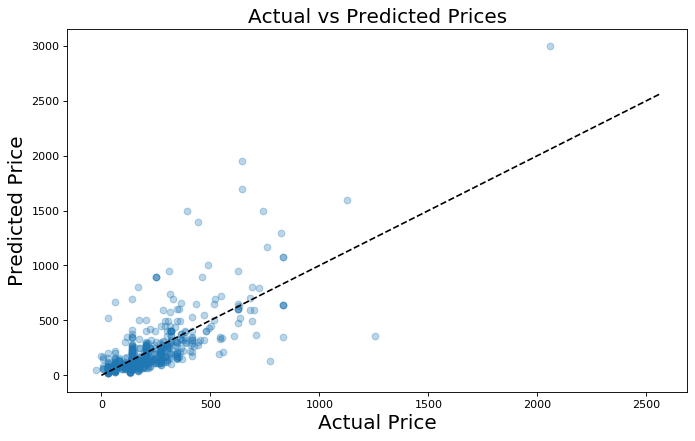

In [27]:
plt.figure(figsize = (10, 6), dpi = 80)
line = np.linspace(0,max(modelsm_fit.predict(X_testsm)) + 500,10001)
plt.scatter(modelsm_fit.predict(X_testsm), y_test, alpha = 0.3)
plt.plot(line, line, 'k--')
plt.xlabel('Actual Price', fontsize = 18)
plt.ylabel('Predicted Price', fontsize = 18)
plt.title('Actual vs Predicted Prices', fontsize = 18)
plt.savefig('images/2pred.png')

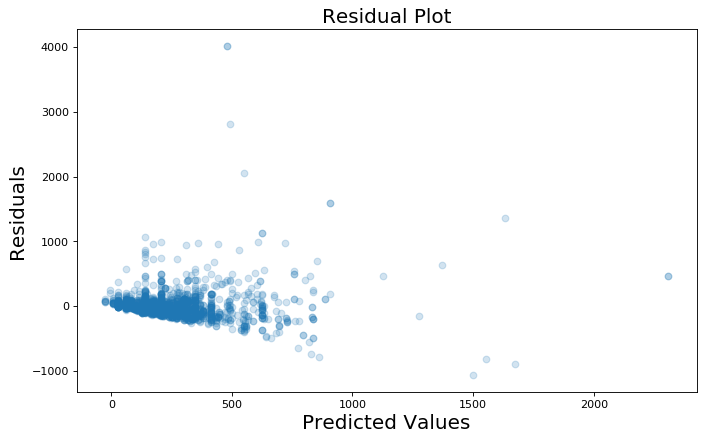

In [28]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.scatter(modelsm_fit.predict(X_trainsm), modelsm_fit.resid, alpha = 0.2)
plt.xlabel('Predicted Values', fontsize = 18)
plt.ylabel('Residuals', fontsize = 18)
plt.title('Residual Plot', fontsize = 18)
plt.savefig('images/2res.png')

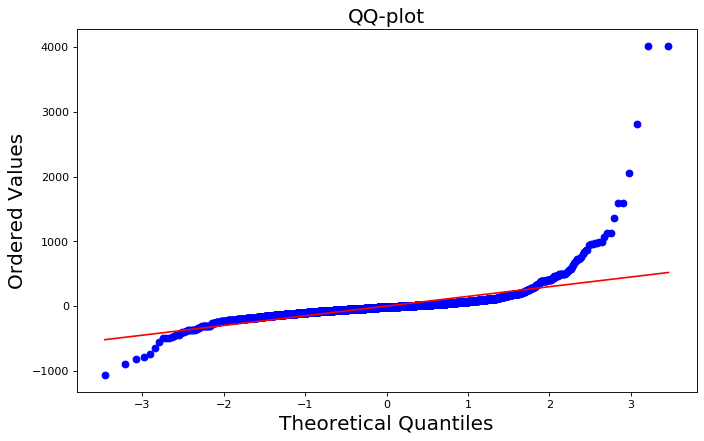

In [29]:
plt.figure(figsize = (10, 6), dpi = 80)
stats.probplot(modelsm_fit.resid, dist = 'norm', plot = plt)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Ordered Values', fontsize = 18)
plt.title('QQ-plot', fontsize = 18)
plt.savefig('images/2qq.png')

In [30]:
df.to_csv('processed_listingsv2.csv', index = False)

***

***

***